In [1]:
#import statements
import requests
import re

import datetime

import os
from os import listdir
from os.path import isfile, join
import zipfile
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc # garbage collector

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import sys
!{sys.executable} -m pip install spacy

import spacy
!{sys.executable} -m spacy download en

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Embedding, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models
from keras import losses
from keras.preprocessing.text import Tokenizer

#Torch
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 12.0 MB 4.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
#downloads all nvdcve-1.1-*.json.zip files
r = requests.get('https://nvd.nist.gov/vuln/data-feeds')

#https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-2021.json.zip

for filename in re.findall("nvdcve-1\.1-[0-9]*\.json\.zip",r.text):
    print(filename)
    r_file = requests.get("https://nvd.nist.gov/feeds/json/cve/1.1/" + filename, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r_file:
            f.write(chunk)

nvdcve-1.1-2022.json.zip
nvdcve-1.1-2021.json.zip
nvdcve-1.1-2020.json.zip
nvdcve-1.1-2019.json.zip
nvdcve-1.1-2018.json.zip
nvdcve-1.1-2017.json.zip
nvdcve-1.1-2016.json.zip
nvdcve-1.1-2015.json.zip
nvdcve-1.1-2014.json.zip
nvdcve-1.1-2013.json.zip
nvdcve-1.1-2012.json.zip
nvdcve-1.1-2011.json.zip
nvdcve-1.1-2010.json.zip
nvdcve-1.1-2009.json.zip
nvdcve-1.1-2008.json.zip
nvdcve-1.1-2007.json.zip
nvdcve-1.1-2006.json.zip
nvdcve-1.1-2005.json.zip
nvdcve-1.1-2004.json.zip
nvdcve-1.1-2003.json.zip
nvdcve-1.1-2002.json.zip


In [3]:
# unzips all files
dir_name = './'
extension = ".zip"

for item in os.listdir(dir_name): 
    if item.endswith(extension): 
        file_name = os.path.abspath(item)
        zip_ref = zipfile.ZipFile(file_name)
        zip_ref.extractall(dir_name)
        zip_ref.close()
        os.remove(file_name)
        

In [4]:
# parses json files
extension = ".json"
all_cves = []
cveID = []
description = []
cvss3 = []
vector3 = []
severity = []
year = []

for item in sorted(os.listdir(dir_name)): 
    if item.endswith(extension): 
        file_name = os.path.abspath(item)
        with open(file_name) as json_file:
            cve_dict = json.loads(json_file.read())
            all_cves = all_cves + cve_dict['CVE_Items']
            json_file.close()

for cves in all_cves:
    cveID.append(cves['cve']['CVE_data_meta']['ID'])
    year_p = cves['cve']['CVE_data_meta']['ID']
    year_p = re.sub('^CVE-','',year_p)
    year_p = re.sub('-\d+$','',year_p)
    year.append(year_p)
    try:
        desc=cves['cve']['description']['description_data']
        desc=str(desc)
        desc = desc[25:]
        desc = desc[:len(desc)-2]
        description.append(desc)
    except:
        description.append("")
    try:
        cvss3.append(int(float(cves['impact']['baseMetricV3']['cvssV3']['baseScore'])*10))
    except:
        cvss3.append(int(0))
    try:
        vector3.append(cves['impact']['baseMetricV3']['cvssV3']['vectorString'])
    except:
        vector3.append("")
    try:
        severity.append(cves['impact']['baseMetricV3']['cvssV3']['baseSeverity'])
    except:
        severity.append("")
        

# control values
print(len(cveID))
print(len(description))
print(len(cvss3))
print(len(vector3))
print(len(severity))
print(len(year))

185600
185600
185600
185600
185600
185600


In [5]:
# creates dataframe
# because Colab crashed due to memory, only Description and CVSS score at this point added into dataframe

#col_names=["CVE_ID","YEAR","DESCRIPTION","CVSS3_BASE","CVSS3_VECTOR","SEVERITY","PROC_DESC"]
col_names=["DESCRIPTION","CVSS3_BASE","PROC_DESC"]
nvd_df=pd.DataFrame(columns=col_names)
#nvd_df.CVE_ID = cveID
nvd_df.DESCRIPTION = description
nvd_df.CVSS3_BASE = cvss3
#nvd_df.CVSS3_VECTOR = vector3
#nvd_df.SEVERITY = severity
#nvd_df.YEAR = year
#nvd_df.YEAR = pd.to_numeric(nvd_df.YEAR)

print(nvd_df.shape)
print(nvd_df.dtypes)

(185600, 3)
DESCRIPTION    object
CVSS3_BASE      int64
PROC_DESC      object
dtype: object


In [6]:
#verifies parsing
nvd_df

,DESCRIPTION,CVSS3_BASE,PROC_DESC
0,'ip_input.c in BSD-derived TCP/IP implementati...,0,NaN
1,'Buffer overflow in NFS mountd gives root acce...,0,NaN
2,'Execute commands as root via buffer overflow ...,0,NaN
3,"'MIME buffer overflow in email clients, e.g. S...",0,NaN
4,'Arbitrary command execution via IMAP buffer o...,0,NaN
...,...,...,...
185595,'USU Oracle Optimization before 5.17 allows au...,0,NaN
185596,'USU Oracle Optimization before 5.17.5 allows ...,0,NaN
185597,"""DJI drone devices sold in 2017 through 2022 b...",0,NaN
185598,'Woodpecker before 0.15.1 allows XSS via build...,0,NaN


In [7]:
# removes rows with no CVSS score
nvd_df = nvd_df[nvd_df.CVSS3_BASE!=0.0]
print("Data with CVSS3",nvd_df.shape)

Data with CVSS3 (101215, 3)


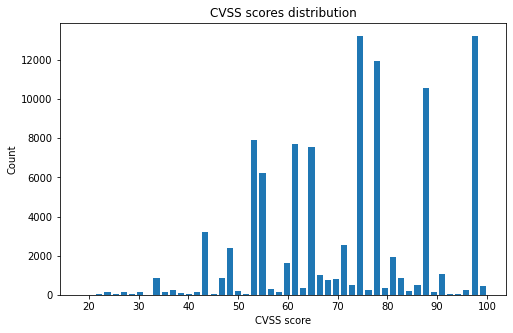

In [8]:
#Plots disctribution of CVE CVSS3.0 scores in residual dataframe
plt.figure(figsize = [8,5])
plt.hist(nvd_df.CVSS3_BASE,rwidth = 0.75, bins = 50)
plt.xlabel("CVSS score")
plt.ylabel("Count")
plt.title("CVSS scores distribution")

plt.show()

In [9]:
# cleans up RAM as runtime crushed on Neural Network model due to lack of RAM
del all_cves
del cveID
del description
del cvss3
del vector3
del severity
del year
gc.collect()

5916

In [10]:
# preprocessing descriptions: remove punctuation, convert to lower case, remove stop words, lemmatization, replaces synonyms
now = datetime.datetime.now()
print ("Current date and time : ",now.strftime("%Y-%m-%d %H:%M:%S"))

en_stopwords = set(stopwords.words('english'))
add_stopwords = ['aka','-','.',' ','  ','      ','via','','-PRON-'] #,'allow','vulnerability','attacker'

def remove_punc(text_string):
    tmp=re.sub('[^a-zA-Z0-9 \.-]', '', text_string.lower())
    tmp=re.sub('^ ',"",tmp)
    return re.sub('\.$','',tmp)

def remove_stopwords(text_string):
    tmp = []
    for token in text_string.split(' '):
      if token not in en_stopwords:
        if token not in add_stopwords:
          tmp.append(token)
    return " ".join([token for token in tmp])

proc_str = []

nlp = spacy.load('en', disable=['parser', 'ner'])

def spacy_lemma(text_string):
    doc = nlp(text_string)
    return " ".join([token.lemma_ for token in doc])

def syn_replace(text_string):
    synonyms = []
    for syn in wordnet.synsets(text_string):
          for l in syn.lemmas():
               synonyms.append(l.name())
    #print(synonyms)
    return " ".join(synonyms)

for desc in nvd_df.DESCRIPTION:
    punct = remove_punc(desc)
    lemmas = spacy_lemma(punct)
    clean = remove_stopwords(lemmas)
    #syn = syn_replace(clean)
    proc_str.append(clean)

nvd_df.PROC_DESC = proc_str

now = datetime.datetime.now()
now = datetime.datetime.now()
print ("Current date and time : ",now.strftime("%Y-%m-%d %H:%M:%S"))

nvd_df

Current date and time :  2022-05-02 18:06:25
Current date and time :  2022-05-02 18:14:13


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DESCRIPTION,CVSS3_BASE,PROC_DESC
198,"""manual/search.texi in the GNU C Library (aka ...",98,manualsearch.texi gnu c library glibc 2.2 lack...
235,'ScriptAlias directory in NCSA and Apache http...,75,scriptalias directory ncsa apache httpd allow ...
1836,'IIS 4.0 and 5.0 allows remote attackers to ca...,75,iis 4.0 5.0 allow remote attacker cause denial...
2820,'crypto/rsa/rsa_gen.c in OpenSSL before 0.9.6 ...,75,cryptorsarsagen.c openssl 0.9.6 mishandle c bi...
6322,'The Diffie-Hellman Key Agreement Protocol all...,75,diffie hellman key agreement protocol allow re...
...,...,...,...
185551,'An issue was discovered in MISP before 2.4.15...,54,issue discover misp 2.4.158 store xss event gr...
185552,'An issue was discovered in MISP before 2.4.15...,48,issue discover misp 2.4.158 xss cerebrate view...
185553,'An issue was discovered in MISP before 2.4.15...,61,issue discover misp 2.4.158 xss appcontrollero...
185554,'An issue was discovered in MISP before 2.4.15...,75,issue discover misp 2.4.158 userscontroller.ph...


In [11]:
# determine max description length
m = []

for item in nvd_df.PROC_DESC:
  i = 0
  for token in item.split(' '):
    if token != ' ':
      i=i+1
  m.append(i)

max = 0

for n in m:
  if n>max:
    max=n


print(max)


557


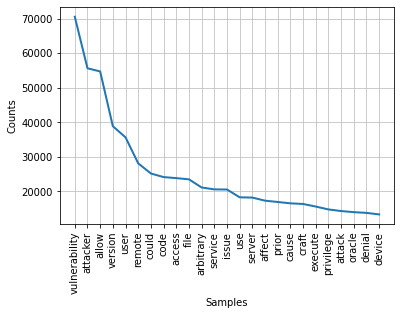

Most common: [('vulnerability', 70533), ('attacker', 55629), ('allow', 54704), ('version', 38868), ('user', 35648), ('remote', 28126), ('could', 25186), ('code', 24148), ('access', 23845), ('file', 23500), ('arbitrary', 21141), ('service', 20591), ('issue', 20552), ('use', 18300), ('server', 18216), ('affect', 17325), ('prior', 16942), ('cause', 16554), ('craft', 16371), ('execute', 15623), ('privilege', 14788), ('attack', 14322), ('oracle', 14002), ('denial', 13790), ('device', 13347)] 

133633


In [12]:
# counts words frequency

words = {}

for item in nvd_df.PROC_DESC:
  for token in item.split(' '):
    if token != ' ':
      try:
        words[token] = words[token] + 1
      except:
        words[token] = 1

freq=nltk.FreqDist()
freq.update(words)
freq.plot(25,cumulative=False)
print("Most common:",freq.most_common(25),"\n")
print(len(words))


In [13]:
# Creates corpus (vocabulary).
corpus = []

for key,val in freq.most_common():
    if val > 5: 
        corpus.append(key)

print(len(corpus))


19693


https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

In [14]:
# tokenization procedure with use of spacy.
tok = spacy.load('en')
def tokenize (text):
    return [token.text for token in tok.tokenizer(text)]

In [15]:
#counts number of occurences of each word
counts = Counter()
for index, row in nvd_df.iterrows():
    counts.update(tokenize(row['PROC_DESC']))

In [16]:
#deletes words that occure in all descriptions less than 5 times
c = 6
print("Number of words (total):",len(counts.keys()))
for word in list(counts):
    if counts[word] < c:
        del counts[word]
print("Number of words after removing words with count <=",c,":",len(counts.keys()))

Number of words (total): 133627
Number of words after removing words with count <= 6 : 19696


In [17]:
#creates vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [18]:
#procedure for words encoding
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [19]:
# encodes sentence (description) into a list of numbers
nvd_df.PROC_DESC = nvd_df.PROC_DESC.apply(lambda x: np.array(encode_sentence(x,vocab2index )))
nvd_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DESCRIPTION,CVSS3_BASE,PROC_DESC
198,"""manual/search.texi in the GNU C Library (aka ...",98,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 10, 11, 12, 13..."
235,'ScriptAlias directory in NCSA and Apache http...,75,"[[1, 27, 1, 28, 29, 17, 18, 30, 31, 32, 0, 0, ..."
1836,'IIS 4.0 and 5.0 allows remote attackers to ca...,75,"[[33, 34, 35, 17, 36, 18, 37, 38, 39, 40, 41, ..."
2820,'crypto/rsa/rsa_gen.c in OpenSSL before 0.9.6 ...,75,"[[1, 48, 49, 50, 3, 1, 51, 52, 53, 54, 55, 56,..."
6322,'The Diffie-Hellman Key Agreement Protocol all...,75,"[[71, 72, 65, 73, 74, 17, 36, 18, 75, 76, 40, ..."


In [21]:
# splits dataframe into train and test

X = nvd_df.PROC_DESC
Y = nvd_df.CVSS3_BASE
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [22]:
#this helper class operates with pytorch Dataset and helps to iterate through it
class CVSSDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [23]:
train_ds = CVSSDataset(X_train.values, Y_train.values)
valid_ds = CVSSDataset(X_test.values, Y_test.values)

In [24]:
# defines procedures for train and validate a model
def train_model(model, epochs=10, lr=0.001):
    EP = []
    ACC = []
    LS = []
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        print("Epoch %d, train loss %.5f, val loss %.5f, val accuracy %.5f, and val rmse %.5f" % (i+1, sum_loss/total, val_loss, val_acc, val_rmse))
        EP.append(i+1)
        ACC.append(val_acc)
        LS.append(val_loss)
    
    #plot graph
    plt.plot(EP, ACC, label='Accuracy')
    plt.plot(EP, LS, label='Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.show()

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [25]:
#defines parameters for dataset iteration
batch_size = 256
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
# helper class to define model
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)          # LSTM layer
        self.linear = nn.Linear(hidden_dim, 101) # Linear output layer. Model should output an integer value from 1 to 100 (100 possible values), that's why dimention is 101.
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [27]:
# defines model with a string of a fixed lenth
model_fixed =  LSTM_fixed_len(vocab_size, max, 50) # max is currently 557

Epoch 1, train loss 2.90919, val loss 2.58347, val accuracy 0.26113, and val rmse 20.26003
Epoch 2, train loss 2.36942, val loss 2.21671, val accuracy 0.38492, and val rmse 15.91882
Epoch 3, train loss 2.13101, val loss 2.10643, val accuracy 0.42049, and val rmse 15.79220
Epoch 4, train loss 2.01381, val loss 2.05516, val accuracy 0.43699, and val rmse 15.21603
Epoch 5, train loss 1.93300, val loss 2.01827, val accuracy 0.45117, and val rmse 15.14211
Epoch 6, train loss 1.87643, val loss 1.98350, val accuracy 0.45932, and val rmse 14.78200
Epoch 7, train loss 1.83191, val loss 1.95787, val accuracy 0.46544, and val rmse 14.65192
Epoch 8, train loss 1.78920, val loss 1.94605, val accuracy 0.46984, and val rmse 14.63643
Epoch 9, train loss 1.76754, val loss 1.94003, val accuracy 0.46984, and val rmse 14.48957
Epoch 10, train loss 1.74715, val loss 1.93189, val accuracy 0.47295, and val rmse 14.76609


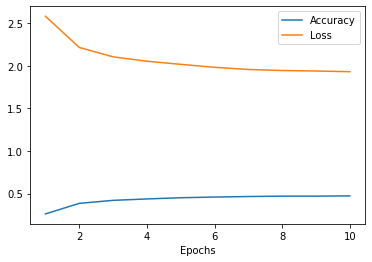

In [28]:
#trains and evaluates model.
epochs = 10

train_model(model_fixed, epochs=epochs, lr=0.01)